# Data Understanding



*   **Month**: This variable represents the date on a monthly basis.
*   **Passengers**: This represents the number of passengers on the corresponding transaction date, indicating the monthly passenger count.



**Import Libraries and Read Data**


In [205]:
# to read and process data
import numpy as np
import pandas as pd
import datetime as dt
import tensorflow as tf
import matplotlib.pyplot as plt

# to evaluate the model and scale the data
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error


# modeling
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# warnings
import warnings
warnings.filterwarnings('ignore')

# Tensorflow warning blocking
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [206]:
df = pd.read_csv("international-airline-passengers.csv")

In [207]:
df.head()

,Month,International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [208]:
df.columns

Index(['Month', 'International airline passengers: monthly totals in thousands. Jan 49 ? Dec 60'], dtype='object')

In [209]:
df.columns = ["Month", "Passengers"]

In [210]:
df.head()

,Month,Passengers
0,1949-01,112.0
1,1949-02,118.0
2,1949-03,132.0
3,1949-04,129.0
4,1949-05,121.0


In [211]:
df.tail()

,Month,Passengers
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0
144,International airline passengers: monthly tota...,NaN


In [212]:
df.shape

(145, 2)

In [213]:
df.dtypes

,0
Month,object
Passengers,float64


In [214]:
df.isnull().sum()

,0
Month,0
Passengers,1


In [215]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


# Data Preparation

In [216]:
# getting rid of the faulty last line

df = df[:144]

In [217]:
df.tail()

,Month,Passengers
139,1960-08,606.0
140,1960-09,508.0
141,1960-10,461.0
142,1960-11,390.0
143,1960-12,432.0


In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Month       144 non-null    object 
 1   Passengers  144 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.4+ KB


In [219]:
# converting object type to datetime for month

df["Month"] = pd.to_datetime(df["Month"])

In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Month       144 non-null    datetime64[ns]
 1   Passengers  144 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 2.4 KB


In [221]:
print("Minimum Date: " , df["Month"].min())
print("Maximum Date: " , df["Month"].max())

Minimum Date:  1949-01-01 00:00:00
Maximum Date:  1960-12-01 00:00:00


In [222]:
# months as index
df.index = df["Month"]

In [223]:
df.head()

,Month,Passengers
Month,,
1949-01-01,1949-01-01,112.0
1949-02-01,1949-02-01,118.0
1949-03-01,1949-03-01,132.0
1949-04-01,1949-04-01,129.0
1949-05-01,1949-05-01,121.0


In [224]:
df.drop("Month", axis=1, inplace=True)

In [225]:
df.head()

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0


In [226]:
result_df = df.copy()

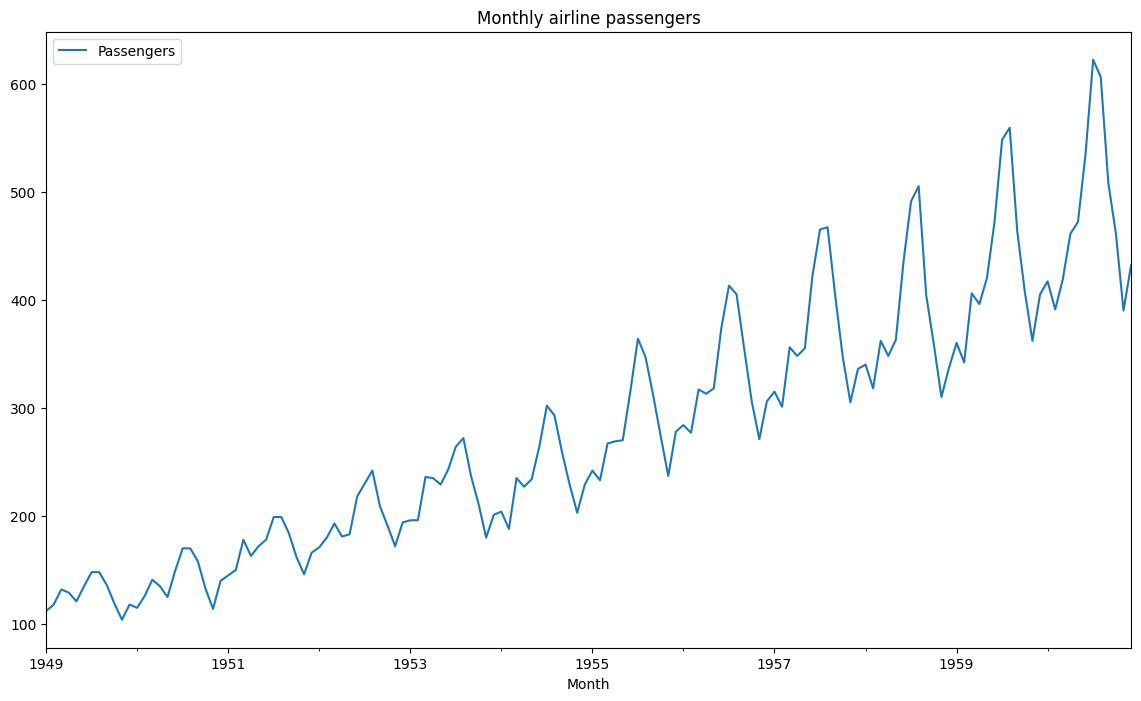

In [227]:
df.plot(
    figsize=(14,8),
    title='Monthly airline passengers'
);

In [228]:
data = df["Passengers"].values

In [229]:
data[0:5]

array([112., 118., 132., 129., 121.])

In [230]:
type(data[0:5])

numpy.ndarray

In [231]:
type(data[0])

numpy.float64

In [232]:
data = data.astype('float32')

In [233]:
type(data[0])

numpy.float32

In [234]:
data.shape

(144,)

In [235]:
data = data.reshape(-1, 1)

In [236]:
data.shape

(144, 1)

# Train & Test Split

In [237]:
def split_data(dataframe, test_size):
  position = int(round(len(dataframe) * (1-test_size)))
  train = dataframe[:position]
  test = dataframe[position:]
  return train, test, position

In [238]:
train, test, position = split_data(data, 0.33)

In [239]:
print(train.shape, test.shape)

(96, 1) (48, 1)


In [240]:
scaler_train = MinMaxScaler(feature_range = (0,1))

In [241]:
train = scaler_train.fit_transform(train)

In [242]:
scaler_test = MinMaxScaler(feature_range= (0,1))

In [243]:
test = scaler_test.fit_transform(test)

In [244]:
train[0:5]

array([[0.02588999],
       [0.04530746],
       [0.09061491],
       [0.08090615],
       [0.05501619]], dtype=float32)

In [245]:
test[0:5]

array([[0.04361373],
       [0.        ],
       [0.17133951],
       [0.1464175 ],
       [0.16822433]], dtype=float32)

In [246]:
def create_features(data, lookback):
  X, Y =  [], []
  for i in range(lookback, len(data)):
    X.append(data[i-lookback:i,0])
    Y.append(data[i,0])

  return np.array(X), np.array(Y)

In [247]:
lookback = 1

In [248]:
# Train Dataset
X_train, y_train = create_features(train, lookback)

In [249]:
# Test Dataset
X_test, y_test = create_features(test, lookback)

In [250]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1) (95,) (47, 1) (47,)


In [251]:
X_train = np.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))
X_test = np.reshape(X_test, (X_test.shape[0], 1, X_test.shape[1]))
y_train = y_train.reshape(-1,1)
y_test = y_test.reshape(-1,1)

In [252]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(95, 1, 1) (95, 1) (47, 1, 1) (47, 1)


# Modeling

In [253]:
model = Sequential()

model.add(SimpleRNN(units=50,
                    activation='relu',
                    input_shape=(X_train.shape[1], lookback)))

model.add(Dropout(0.2))

model.add(Dense(1))

In [254]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn_3 (SimpleRNN)             │ (None, 50)                  │           2,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,651 (10.36 KB)

 Trainable params: 2,651 (10.36 KB)

 Non-trainable params: 0 (0.00 B)

# Optimization and Evaluation Metrics

In [255]:
model.compile(loss='mean_squared_error', optimizer='adam')

In [256]:
callbacks = [EarlyStopping(monitor='val_loss',
                           patience=3,
                           verbose=1,
                           mode="min"),
             ModelCheckpoint(filepath='mymodel.keras',
                             monitor='val_loss',
                             mode='min',
                             save_best_only=True,
                             save_weights_only=False,
                             verbose=1)]

In [257]:
history = model.fit(x=X_train,
                    y=y_train,
                    epochs=50,
                    batch_size=1,
                    validation_data=(X_test, y_test),
                    callbacks=callbacks,
                    shuffle=False)

Epoch 1/50
94/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0040
Epoch 1: val_loss improved from inf to 0.02612, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.0041 - val_loss: 0.0261
Epoch 2/50
77/95 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0133
Epoch 2: val_loss improved from 0.02612 to 0.02391, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0131 - val_loss: 0.0239
Epoch 3/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0073
Epoch 3: val_loss improved from 0.02391 to 0.02088, saving model to mymodel.keras
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 0.0074 - val_loss: 0.0209
Epoch 4/50
80/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0045
Epoch 4: val_loss did not improve from 0.02088
95/95 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0049 - val_loss: 0.0245
Epoch 5/50
89/95 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0056
Epoch 5: val_loss did not improve from 0.02088
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 

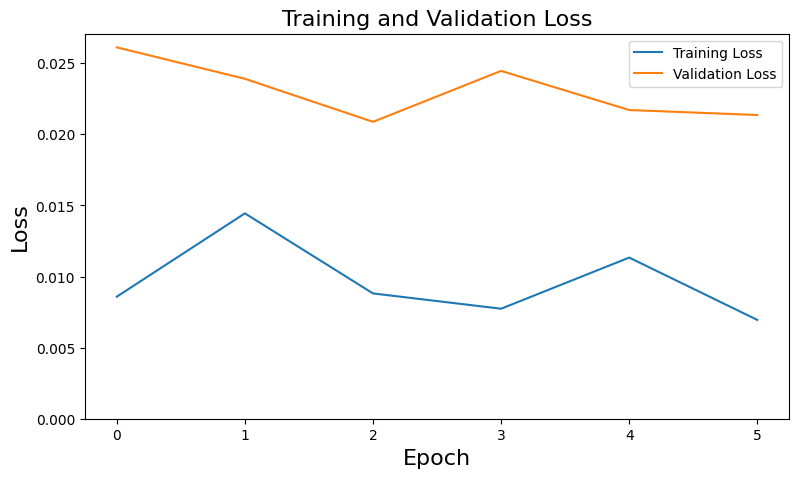

In [258]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss', fontsize=16)
plt.show()

# Evaluation

In [259]:
loss = model.evaluate(X_test, y_test, batch_size=1)
print("\nTest loss: %.1f%%" % (100.0 * loss))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0168

Test loss: 2.1%


In [261]:
train_predict = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [262]:
test_predict = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [263]:
train_predict = scaler_train.inverse_transform(train_predict)
test_predict = scaler_test.inverse_transform(test_predict)

In [264]:
y_train = scaler_train.inverse_transform(y_train)
y_test = scaler_test.inverse_transform(y_test)

In [265]:
# RMSE for Train Set

train_rmse = np.sqrt(mean_squared_error(y_train, train_predict))

In [266]:
# RMSE for Test Set

test_rmse = np.sqrt(mean_squared_error(y_test, test_predict))

In [267]:
print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")

Train RMSE: 23.47268295288086
Test RMSE: 46.91288375854492


In [268]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Passengers,144.0,280.298611,119.966317,104.0,180.0,265.5,360.5,622.0


In [269]:
result_df

,Passengers
Month,
1949-01-01,112.0
1949-02-01,118.0
1949-03-01,132.0
1949-04-01,129.0
1949-05-01,121.0
...,...
1960-08-01,606.0
1960-09-01,508.0
1960-10-01,461.0


In [270]:
train_prediction_df = result_df[lookback:position]

In [271]:
train_prediction_df["Predicted"] = train_predict

In [272]:
train_prediction_df.head()

,Passengers,Predicted
Month,,
1949-02-01,118.0,126.754883
1949-03-01,132.0,131.157455
1949-04-01,129.0,143.912582
1949-05-01,121.0,141.024429
1949-06-01,135.0,133.437103


In [273]:
test_prediction_df = result_df[position+lookback:]
test_prediction_df["Predicted"] = test_predict
test_prediction_df.head()

,Passengers,Predicted
Month,,
1957-02-01,301.0,328.800659
1957-03-01,356.0,320.015350
1957-04-01,348.0,367.408966
1957-05-01,355.0,359.707275
1957-06-01,422.0,366.446320


# Visualization of Train and Test Predictions

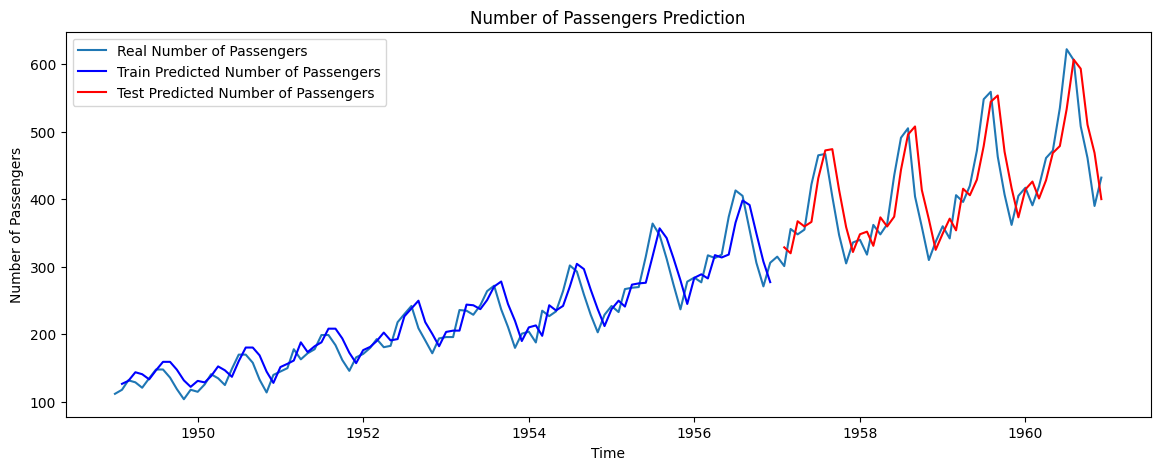

In [274]:
plt.figure(figsize=(14,5))
plt.plot(result_df, label = 'Real Number of Passengers')
plt.plot(train_prediction_df["Predicted"], color = 'blue', label = 'Train Predicted Number of Passengers')
plt.plot(test_prediction_df["Predicted"], color = 'red', label = 'Test Predicted Number of Passengers')
plt.title('Number of Passengers Prediction')
plt.xlabel('Time')
plt.ylabel('Number of Passengers')
plt.legend()
plt.show()